In [32]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [33]:
num_pix = 45
exposure_time = 146
detector = 1
band = 'F129'

In [34]:
# ra = random.uniform(15, 45)
# dec = random.uniform(-45, -15)
# date = datetime.datetime(year=2027, month=7, day=7, hour=0, minute=0, second=0)

In [35]:
ra = 30
dec = -30

wcs_dict = gs.get_wcs(ra, dec, date=None)

# get bandpass object
bandpass = gs.get_bandpass(band)

# get wcs
wcs = wcs_dict[detector]

# build Image
sky_image = galsim.ImageF(num_pix, num_pix, wcs=wcs)

sca_cent_pos = wcs.toWorld(sky_image.true_center)
sky_level = galsim.roman.getSkyLevel(bandpass, world_pos=sca_cent_pos, exptime=exposure_time)
print(f'{sky_level:.2f} e-/arcsec^2')

19165.80 e-/arcsec^2


convert this sky level I've been defaulting to for SNR calculation to something I can compare to Roman technical specifications

Roman technical specifications gives count rates per pixel for zodiacal light, which is what sky background is

as of June 3, 2024, https://roman.gsfc.nasa.gov/science/WFI_technical.html says 0.267 counts/pixel for F129

In [36]:
sky_level /= exposure_time
print(f'{sky_level} e-/arcsec^2/sec')
sky_level *= 0.11 ** 2
print(f'{sky_level} e-/pixel/sec')

131.27263545784015 e-/arcsec^2/sec
1.5883988890398657


In [37]:
expected_sky_level = 0.267 * 1.5
print(f'{expected_sky_level:.2f} e-/pixel/sec')
print(
    f'{util.percent_difference(expected_sky_level, sky_level):.2f}% difference, factor {sky_level / expected_sky_level:.2f}')

0.40 e-/pixel/sec
119.45% difference, factor 3.97


In [38]:
points = 10
sky_level_array = np.empty((points, points))

for i, ra in tqdm(enumerate(np.linspace(15, 45, points)), total=points):
    for j, dec in enumerate(np.linspace(-45, -15, points)):
        wcs_dict = gs.get_wcs(ra, dec, date=None)
        wcs = wcs_dict[detector]
        sky_image = galsim.ImageF(num_pix, num_pix, wcs=wcs)
        sca_cent_pos = wcs.toWorld(sky_image.true_center)
        sky_level = galsim.roman.getSkyLevel(bandpass, world_pos=sca_cent_pos, exptime=exposure_time)
        sky_level /= exposure_time
        sky_level *= 0.11 ** 2
        sky_level_array[i][j] = sky_level

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


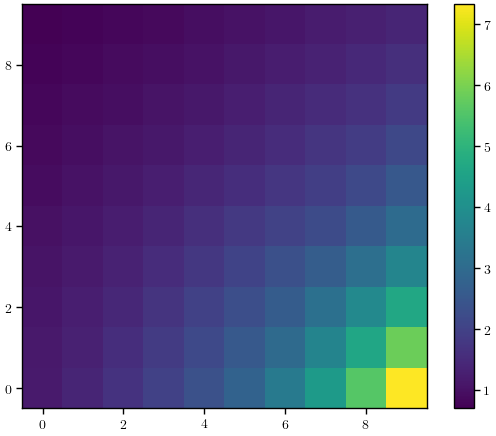

In [39]:
plt.imshow(sky_level_array)
plt.colorbar()
plt.show()

In [40]:
sky_level *= (1. + galsim.roman.stray_light_fraction)
wcs.makeSkyImage(sky_image, sky_level)
print(galsim.roman.stray_light_fraction)

0.1


In [41]:
thermal_bkg = galsim.roman.thermal_backgrounds[gs.get_bandpass_key(band)] * exposure_time
print(thermal_bkg)
sky_image += thermal_bkg

0.0


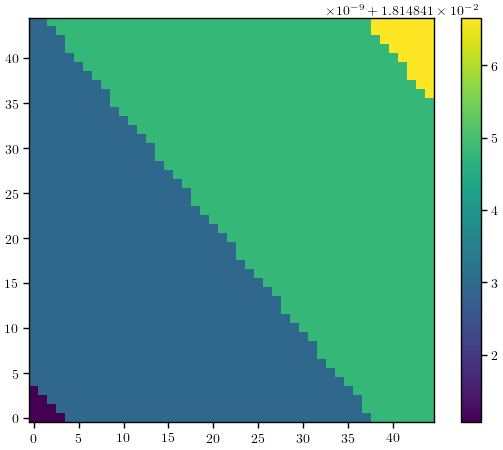

In [42]:
plt.imshow(sky_image.array)
plt.colorbar()
plt.show()

In [45]:
from mejiro.instruments.roman import Roman

roman_params = Roman()

bands = ['F106', 'F129', 'F158', 'F184']

bkgs = {}
for band in bands:
    # build Image
    sky_image = galsim.ImageF(num_pix, num_pix)

    # get minimum zodiacal light in this band in counts/pixel/sec
    sky_level = roman_params.get_min_zodi(band)

    # "For observations at high galactic latitudes, the Zodi intensity is typically ~1.5x the minimum" (https://roman.gsfc.nasa.gov/science/WFI_technical.html)
    sky_level *= 1.5

    # the stray light level is currently set in GalSim to a pessimistic 10% of sky level
    sky_level *= (1. + galsim.roman.stray_light_fraction)

    # get thermal background in this band in counts/pixel/sec
    thermal_bkg = roman_params.get_thermal_bkg(band)

    # combine the two backgrounds (still counts/pixel/sec)
    sky_image += sky_level
    sky_image += thermal_bkg

    # convert to counts/pixel
    sky_image *= exposure_time

    bkgs[band] = sky_image

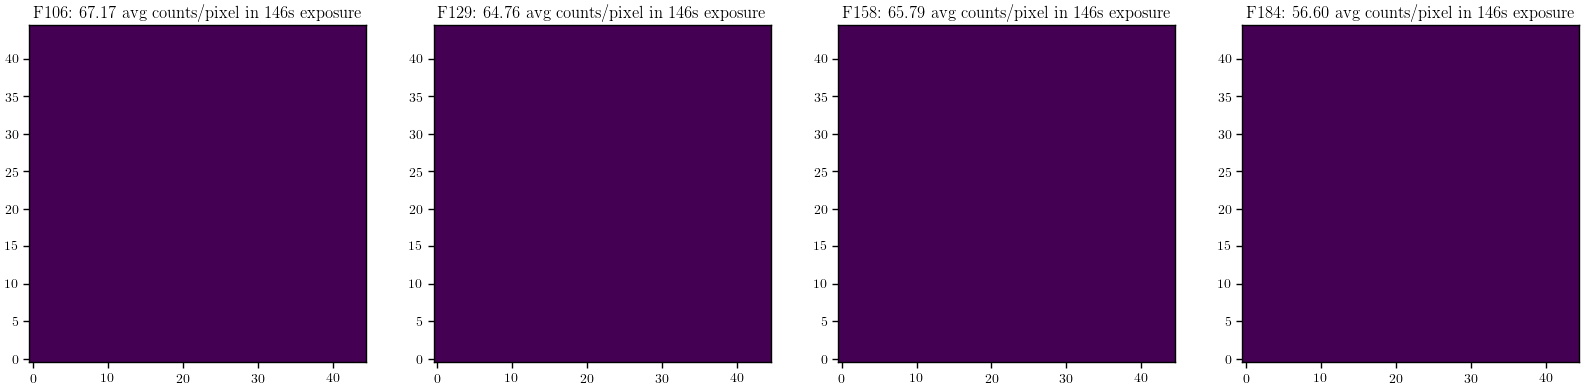

In [47]:
_, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, band in enumerate(bands):
    ax[i].imshow(bkgs[band].array)
    ax[i].set_title(f'{band}: {bkgs[band].array.mean():.2f} avg counts/pixel in 146s exposure')

plt.show()